### In this notebook we see the kill_one_qubit

In [3]:
import gc
import numpy as np
import sympy
import cirq
import tensorflow_quantum as tfq
from tqdm import tqdm
import tensorflow as tf
import argparse
import os
import pickle
import matplotlib.pyplot as plt

In [25]:
class Solver:
    def __init__(self, n_qubits=3, qlr=0.01, qepochs=100,verbose=0, g=1, J=0, noise=False, noise_level=0.01):

        self.n_qubits = n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.lower_bound_Eg = -2*self.n_qubits

        self.qlr = qlr
        self.qepochs=qepochs
        self.verbose=verbose


        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        self.final_params = []
        self.single_qubit_unitaries = {"rx":cirq.rx, "rz":cirq.rz}
        
        self.observable=self.ising_obs(g=g, J=J)
        
        self.noise = noise
        self.noise_level = noise_level
        
    def ising_obs(self, g=1, J=0):
        self.g=g
        self.J=J
        observable = [-float(0.5*g)*cirq.Z.on(q) for q in self.qubits]
        for q in range(len(self.qubits)):
            observable.append(-float(0.5*J)*cirq.X.on(self.qubits[q])*cirq.X.on(self.qubits[(q+1)%len(self.qubits)]))
        return observable
    
    def append_to_circuit(self, ind, circuit, params, index_to_symbols):
        #### add CNOT
        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            if isinstance(index_to_symbols,dict):
                index_to_symbols[len(list(index_to_symbols.keys()))] = []
                return circuit, params, index_to_symbols
            else:
                return circuit, params

        #### add rz #####
        elif 0 <= ind - self.number_of_cnots  < self.n_qubits:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(1),[cirq.rz]):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
                index_to_symbols[len(list(index_to_symbols.keys()))] = new_param
                return circuit, params, index_to_symbols

        #### add rx #####
        elif self.n_qubits <= ind - self.number_of_cnots  < 2*self.n_qubits:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(1),[cirq.rx]):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
                index_to_symbols[len(list(index_to_symbols.keys()))] = new_param
            return circuit, params, index_to_symbols
            
    def give_unitary(self,idx, res):
        return cirq.resolve_parameters(self.give_circuit(idx)[0], res)

    def give_circuit(self, lista):
        circuit, symbols, index_to_symbols = [], [], {}
        for k in lista:
            circuit, symbols, index_to_symbols = self.append_to_circuit(k,circuit,symbols, index_to_symbols)
        circuit = cirq.Circuit(circuit)
        return circuit, symbols, index_to_symbols

    def resolution_2cnots(self, q1, q2):
        rzq1 = self.number_of_cnots + q1
        rzq2 = self.number_of_cnots +  q2
        rxq1 = self.number_of_cnots + self.n_qubits + q1
        rxq2 = self.number_of_cnots + self.n_qubits + q2
        cnot = self.cnots_index[str([q1,q2])]
        return [cnot, rzq1, rxq1, rzq1,  rzq2, rxq2, rzq2, cnot]

    def resolution_1qubit(self, q):
        rzq1 = self.number_of_cnots +  q1
        rxq1 = self.number_of_cnots + self.n_qubits + q1
        return [rzq1, rxq1, rzq1]

    def rotation(self,vals):
        alpha,beta,gamma = vals
        return np.array([[np.cos(beta/2)*np.cos(alpha/2 + gamma/2) - 1j*np.cos(beta/2)*np.sin(alpha/2 + gamma/2),
                 (-1j)*np.cos(alpha/2 - gamma/2)*np.sin(beta/2) - np.sin(beta/2)*np.sin(alpha/2 - gamma/2)],
                [(-1j)*np.cos(alpha/2 - gamma/2)*np.sin(beta/2) + np.sin(beta/2)*np.sin(alpha/2 - gamma/2),
                 np.cos(beta/2)*np.cos(alpha/2 + gamma/2) + 1j*np.cos(beta/2)*np.sin(alpha/2 + gamma/2)]])


    def give_rz_rx_rz(self,u):
        """
        finds \alpha, \beta \gamma s.t m = Rz(\alpha) Rx(\beta) Rz(\gamma)
        ****
        input: 2x2 unitary matrix as numpy array
        output: [\alpha \beta \gamma]
        """
        a = sympy.Symbol("a")
        b = sympy.Symbol("b")
        g = sympy.Symbol("g")

        eqs = [sympy.exp(-sympy.I*.5*(a+g))*sympy.cos(.5*b) ,
               -sympy.I*sympy.exp(-sympy.I*.5*(a-g))*sympy.sin(.5*b),
                sympy.exp(sympy.I*.5*(a+g))*sympy.cos(.5*b)
              ]

        kk = np.reshape(u, (4,))
        s=[]
        for i,r in enumerate(kk):
            if i!=2:
                s.append(r)

        t=[]
        for eq, val in zip(eqs,s):
            t.append((eq)-np.round(val,5))

        ### this while appears since the seed values may enter in vanishing gradients and through Matrix-zero error.
        error=True
        while error:
            try:
                solution = sympy.nsolve(t,[a,b,g],np.pi*np.array([np.random.random(),np.random.random(),np.random.random()]) ,maxsteps=3000, verify=True)
                vals = np.array(solution.values()).astype(np.complex64)
                #print(np.round(rotation(vals),3)-m)
                error=False
            except Exception:
                error=True
        return vals
    
    
    def TFQ_model(self, symbols, lr):
        circuit_input = tf.keras.Input(shape=(), dtype=tf.string)

        if self.noise is True:
            output = tfq.layers.Expectation(backend=cirq.DensityMatrixSimulator(noise=cirq.depolarize(self.noise_level)))(
                    circuit_input,
                    symbol_names=symbols,
                    operators=tfq.convert_to_tensor([self.observable]),
                    initializer=tf.keras.initializers.RandomNormal(stddev=np.pi/2))

        else:
            output = tfq.layers.Expectation()(
                    circuit_input,
                    symbol_names=symbols,
                    operators=tfq.convert_to_tensor([self.observable]),
                    initializer=tf.keras.initializers.RandomNormal(stddev=np.pi/2))

        model = tf.keras.Model(inputs=circuit_input, outputs=output)
        adam = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=adam, loss='mse')
        return model


    def compute_energy_first_time(self, circuit, symbols, hyperparameters):
        """
        takes as input vector with actions described as integer
        and outputsthe energy of that circuit (w.r.t self.observable)

        hyperparameters = [epoch, lr]
        """

        ### this is because each qubit should be "activated" in TFQ to do the optimization (if the observable has support on this qubit as well and you don't add I then error)
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))

        tfqcircuit = tfq.convert_to_tensor([circuit])

        model = self.TFQ_model(symbols, hyperparameters[1])
        qoutput = tf.ones((1, 1))*self.lower_bound_Eg ##### important to discuss with Lucksasz.
        #print("about to fit!")
        h=model.fit(x=tfqcircuit, y=qoutput, batch_size=1,
                    epochs=hyperparameters[0], verbose=self.verbose, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, mode="min")])
        energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
        final_params = model.trainable_variables[0].numpy()
        resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
        del model
        gc.collect()

        return resolver, energy,h


    def simplify_circuit(self,indexed_circuit, index_to_symbols, symbol_to_value):

        connections={str(q):[] for q in range(self.n_qubits)} #this saves the gates in each qubit. Notice that this does not necessarily respects the order.
        places_gates = {str(q):[] for q in range(self.n_qubits)} #this saves, for each gate on each qubit, the position in the original indexed_circuit

        flagged = [False]*len(indexed_circuit) #to check if you have seen a cnot already, so not to append it twice to the qubit's dictionary

        for nn,idq in enumerate(indexed_circuit): #sweep over all gates in original circuit's vector
            for q in range(self.n_qubits): #sweep over all qubits
                if idq<self.number_of_cnots: #if the gate it's a CNOT or not
                    control, target = self.indexed_cnots[str(idq)] #give control and target qubit
                    if q in [control, target] and not flagged[nn]: #if the qubit we are looking at is affected by this CNOT, and we haven't add this CNOT to the dictionary yet
                        connections[str(control)].append(idq)
                        connections[str(target)].append(idq)
                        places_gates[str(control)].append(nn)
                        places_gates[str(target)].append(nn)
                        flagged[nn] = True #so you don't add the other
                else:
                    if (idq-self.number_of_cnots)%self.n_qubits == q: #check if the unitary is applied to the qubit we are looking at
                        if 0 <= idq - self.number_of_cnots< self.n_qubits:
                            connections[str(q)].append("rz")
                        elif self.n_qubits <= idq-self.number_of_cnots <  2*self.n_qubits:
                            connections[str(q)].append("rx")
                        places_gates[str(q)].append (nn)
                    flagged[nn] = True #to check that all gates have been flagged

        new_indexed_circuit = indexed_circuit.copy()
        new_indexed_circuit_unitary = [False for k in indexed_circuit]
        NRE ={}
        symbols_to_delete=[]
        symbols_on = {str(q):[] for q in list(connections.keys())}

        for q, path in connections.items(): ###sweep over qubits: path is all the gates that act this qubit during the circuit
            for ind,gate in enumerate(path):

                ##### CNOTS ONLY ####
                ##### CNOTS ONLY ####
                if gate in range(self.number_of_cnots) and ind == 0 and not new_indexed_circuit[places_gates[str(q)][ind]] == -1: ###if I have a CNOT just before initializing, it does nothing (if |0> initialization).
                    others = self.indexed_cnots[str(gate)].copy()
                    others.remove(int(q)) #the other qubit affected by the CNOT
                    for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                        if jgate == gate and jind==0: ##it's also the first gate in the other qubit
                            if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]): #check that positions in the indexed_circuit are the same
                                new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                break

                elif gate in range(self.number_of_cnots) and ind<len(path)-1 and not (new_indexed_circuit[places_gates[str(q)][ind]] == -1 and new_indexed_circuit[places_gates[str(q)][ind+1]] == -1): ### self.number_of_cnots is the maximum index of a CNOT gate for a fixed self.n_qubits.
                    if path[ind+1]==gate and not (new_indexed_circuit[places_gates[str(q)][ind]] == -1): #check if the next gate is the same CNOT; and check if I haven't corrected the original one (otherwise you may simplify 3 CNOTs to id)
                        others = self.indexed_cnots[str(gate)].copy()
                        others.remove(int(q)) #the other qubit affected by the CNOT
                        for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                            if jgate == gate and connections[str(others[0])][jind+1] == gate: ##i find the same gate that is repeated in both the original qubit and this one
                                if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]) and (places_gates[str(q)][ind+1] == places_gates[str(others[0])][jind+1]): #check that positions in the indexed_circuit are the same
                                 ###maybe I changed before, so I have repeated in the original but one was shut down..
                                    new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                    new_indexed_circuit[places_gates[str(q)][ind+1]] = -1 ###just kill the repeated CNOTS
                                    break
                ##### CNOTS ONLY ####
                ##### CNOTS ONLY ####

                #### ROTATIONS ####
                elif gate in ["rz","rx"] and not new_indexed_circuit[places_gates[str(q)][ind]] == -1:
                    finish_here = False

                    gates = ["rz", "rx"]
                    gates.remove(gate)
                    other_gate = gates[0]

                    original_symbol = index_to_symbols[places_gates[str(q)][ind]]
                    original_value = symbol_to_value[original_symbol]

                    if ind==0 and gate=="rz": ### RZ AT BEGGINING DOES NOTHING
                        symbols_to_delete.append(original_symbol)
                        new_indexed_circuit[places_gates[str(q)][ind]] = -1
                        finish_here = True


                    elif ind != len(path)-1:
                        #### two equal rotations: addd values
                        if path[ind+1] == gate and not new_indexed_circuit[places_gates[str(q)][ind+1]] == -1:
                            next_symbol = index_to_symbols[places_gates[str(q)][ind+1]]
                            symbols_to_delete.append(next_symbol)
                            new_indexed_circuit[places_gates[str(q)][ind+1]] = -1

                            sname="th_"+str(len(list(NRE.keys()))) ## this is safe, since we are looping on the indices first, and the resolver dict is ordered
                            NRE[sname] = original_value + symbol_to_value[next_symbol]
                            symbols_on[str(q)].append(sname)
                            finish_here = True

                        #### IF YOU HAVE ENOUGH EXPRESSIVITY..
                        elif ind< len(path)-2:
                            if path[ind+1] == other_gate and path[ind+2] == gate:
                                compile_gate = False
                                gate_to_compile = [self.single_qubit_unitaries[gate](original_value).on(self.qubits[int(q)])]

                                for pp in [1,2]:
                                    gate_to_compile.append(self.single_qubit_unitaries[path[ind+pp]](symbol_to_value[index_to_symbols[places_gates[str(q)][ind+pp]]]).on(self.qubits[int(q)]))

                                for ilum, next_gates_to_compile in enumerate(path[(ind+3):]):
                                    if next_gates_to_compile in ["rz","rx"] and not new_indexed_circuit[places_gates[str(q)][ind+3+ilum]] == -1:
                                        compile_gate = True #we'll compile!

                                        new_indexed_circuit[places_gates[str(q)][ind+3+ilum]] = -1
                                        dele = index_to_symbols[places_gates[str(q)][ind+3+ilum]]
                                        symbols_to_delete.append(dele)

                                        gate_to_compile.append(self.single_qubit_unitaries[next_gates_to_compile](symbol_to_value[dele]).on(self.qubits[int(q)]))
                                    else:
                                        break
                                if compile_gate:
                                    u = cirq.unitary(cirq.Circuit(gate_to_compile))
                                    vals = np.real(self.give_rz_rx_rz(u)[::-1]) #not entirely real since finite number of iterations

                                    #### make sure this is rz rx rz
                                    new_indexed_circuit[places_gates[str(q)][ind]] = self.number_of_cnots+int(q)
                                    new_indexed_circuit[places_gates[str(q)][ind+1]] = self.number_of_cnots+int(q)+self.n_qubits
                                    new_indexed_circuit[places_gates[str(q)][ind+2]] = self.number_of_cnots+int(q)

                                    for o in range(3):
                                        new_indexed_circuit_unitary[places_gates[str(q)][ind+o]] = True

                                    for v in zip(list(vals)):
                                        sname="th_"+str(len(list(NRE.keys()))) ## this is safe, since we are looping on the indices first, and the resolver dict is ordered
                                        NRE[sname] = v[0]
                                        symbols_on[str(q)].append(sname)
                                    finish_here = True


                            elif gate in ["rz","rx"] and path[ind+1] not in ["rx", "rz","u"]:
                                control, target = self.indexed_cnots[str(path[ind+1])]
                                if int(q) == control:
                                    if gate == "rz":# and not :
                                        values_added=[]
                                        for npip, pip in enumerate(path[ind+2:]):
                                            if new_indexed_circuit[places_gates[str(q)][ind+2+npip]] == -1:
                                                break
                                            else:
                                                if pip not in ["rz", "rx"]: # it's a cnot
                                                    if not self.indexed_cnots[str(pip)][0] == int(q): #i still have this control!
                                                        break
                                                else:
                                                    break
                                                    
                                            
                                        if ind+2+npip < len(path) and npip>0:
                                            if path[ind+2+npip] == "rz":
                                                next_symbol = index_to_symbols[places_gates[str(q)][ind+2+npip]]
                                                symbols_to_delete.append(next_symbol)
                                                new_indexed_circuit[places_gates[str(q)][ind+2+npip]] = -1
                                                value_to_add = symbol_to_value[next_symbol]
                                                
                                                sname="th_"+str(len(list(NRE.keys()))) ## this is safe, since we are looping on the indices first, and the resolver dict is ordered
                                                NRE[sname] = original_value + value_to_add
                                                symbols_on[str(q)].append(sname)
                                                finish_here = True

                                if int(q) == target:
                                    if gate == "rx":# and not :
                                        values_added=[]
                                        for npip, pip in enumerate(path[ind+2:]):
                                            if new_indexed_circuit[places_gates[str(q)][ind+2+npip]] == -1:
                                                break
                                            else:
                                                if pip not in ["rz", "rx"]: # it's a cnot
                                                    if not self.indexed_cnots[str(pip)][1] == int(q): #i still have this target!
                                                        break
                                                else:
                                                    break
                                                    
                                            
                                        if ind+2+npip < len(path) and npip>0:
                                            if path[ind+2+npip] == "rx":
                                                next_symbol = index_to_symbols[places_gates[str(q)][ind+2+npip]]
                                                symbols_to_delete.append(next_symbol)
                                                new_indexed_circuit[places_gates[str(q)][ind+2+npip]] = -1
                                                value_to_add = symbol_to_value[next_symbol]
                                                
                                                sname="th_"+str(len(list(NRE.keys()))) ## this is safe, since we are looping on the indices first, and the resolver dict is ordered
                                                NRE[sname] = original_value + value_to_add
                                                symbols_on[str(q)].append(sname)
                                                finish_here = True



                    if finish_here == False and new_indexed_circuit_unitary[places_gates[str(q)][ind]] == False:
                        sname="th_"+str(len(list(NRE.keys()))) ## this is safe, since we are looping on the indices first, and the resolver dict is ordered
                        NRE[sname] = original_value
                        symbols_on[str(q)].append(sname)




        #### TRANSLATE THIS TO THE OUTPUT
        final=[]
        final_idx_to_symbols={}
        final_dict = {}

        index_gate=0
        for gmarked in new_indexed_circuit:
            if not gmarked == -1:
                final.append(gmarked)
                if 0 <= gmarked - self.number_of_cnots < 2*self.n_qubits:

                    ### in which position we add this symbol ?
                    for indd, k in enumerate(symbols_on[str((gmarked - self.number_of_cnots)%self.n_qubits)]):
                        if k != -1:
                            break
                    final_idx_to_symbols[int(len(final)-1)] = "th_"+str(len(list(final_dict.keys())))
                    final_dict["th_"+str(len(list(final_dict.keys())))] = NRE[symbols_on[str((gmarked - self.number_of_cnots)%self.n_qubits)][indd]]
                    
                    symbols_on[str((gmarked - self.number_of_cnots)%self.n_qubits)][indd]=-1
                else:
                    final_idx_to_symbols[int(len(final)-1)] = ""

        return final, final_idx_to_symbols, final_dict

    def check_qubits_on(self,circuit):
        """function that checks if all qubits are touched by a gate in the circuit"""
        check = True
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                check = False
                break
        return check
    
    def reduce_circuit(self, indexed_circuit, index_to_symbols, symbol_to_value, max_its=None):
        """iterate many times simplify circuit, break if you have
        no gates on a given qubit (can happen after applying kill_unitary, if the circuit is no good enough)"""
        
        l0 = len(indexed_circuit)
        reducing = True
        
        if max_its is None:
            max_its = l0

        for its in range(max_its):
            if len(indexed_circuit) == l0 or self.check_qubits_on(self.give_circuit(indexed_circuit)[0]) is False:
                reducing = False
            indexed_circuit, index_to_symbols, symbol_to_value = self.simplify_circuit(indexed_circuit, index_to_symbols, symbol_to_value) #it would be great to have a way to realize that insertion was trivial...RL? :-)

        return indexed_circuit, index_to_symbols, symbol_to_value

    def kill_one_unitary(self, indexed_circuit, index_to_symbols, symbol_to_value, historial_lowest_energy=-0.01, mode="best_ever"):
        """notice this accepts either indexed_circuit that encode u = [rz rx rz] or single gates (rz, rx).
            Importantly symbol_to_value respects the order of indexed_circuit.
        """
        circuit_proposals=[] #storing all good candidates.
        circuit_proposals_energies=[]

        ### def expectation layer according to noise presence or not
        if self.noise is True:
            expectation_layer = tfq.layers.Expectation(backend=cirq.DensityMatrixSimulator(noise=cirq.depolarize(self.noise_level)))
        else:
            expectation_layer = tfq.layers.Expectation()

        ### to which energy do we compare with ?
        if mode=="best_ever":
            compare_energy=historial_lowest_energy
        else:
            tfqcircuit_gates_index_energy = tfq.convert_to_tensor([cirq.resolve_parameters(self.give_circuit(indexed_circuit)[0], symbol_to_value)]) 
            expval_gates_index = expectation_layer(  tfqcircuit_gates_index_energy,
                                    operators=tfq.convert_to_tensor([self.observable]))
            gates_index_energy = np.float32(np.squeeze(tf.math.reduce_sum(expval_gates_index, axis=-1, keepdims=True)))
            compare_energy = gates_index_energy

        #sweep over indexed_circuit
        for i1, j in enumerate(indexed_circuit):
            indexed_prop=[]
            prop=cirq.Circuit()
            checking = False
            ko=0
            to_pop=[]

            for i2, k in enumerate(indexed_circuit):
                if k < self.number_of_cnots:
                    indexed_prop.append(k)
                    control, target = self.indexed_cnots[str(k)]
                    prop.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
                else:
                    if i1 != i2:
                        indexed_prop.append(k)
                        qubit = self.qubits[(k-self.number_of_cnots)%self.n_qubits]
                        if 0 <= k-self.number_of_cnots < self.n_qubits:
                            new_param = "th_"+str(ko)
                            ko+=1
                            prop.append(cirq.rz(sympy.Symbol(new_param)).on(qubit))

                        if self.n_qubits <= k-self.number_of_cnots < 2*self.n_qubits:
                            new_param = "th_"+str(ko)
                            ko+=1
                            prop.append(cirq.rx(sympy.Symbol(new_param)).on(qubit))

                    else: #i1 == i2
                        checking=True
                        to_pop.append("th_"+str(ko))
                        ko+=1

            ### checking is True when you found a parametrized gate
            if checking is True:
                reject = False
                nr = symbol_to_value.copy()
                for p in to_pop:
                    nr.pop(p)

                #### If I have no qubits touched by a gate, just try another one
                connections={str(q):[] for q in range(self.n_qubits)} #this saves the gates in each qubit. Notice that this does not necessarily respects the order.
                for nn,idq in enumerate(indexed_prop): #sweep over all gates in original circuit's vector
                    for q in range(self.n_qubits): #sweep over all qubits
                        if (idq-self.number_of_cnots)%self.n_qubits == q and (idq>=self.number_of_cnots): #check if the unitary is applied to the qubit we are looking at
                            connections[str(q)].append("hey you") # ["hey you"] != [] -> reject True
                for q in range(self.n_qubits): #sweep over all qubits
                    if connections[str(q)] == []:
                        reject = True
                        break

                # if you survive the check, compute energy when killing corresponding gate
                if reject is False:
                    tfqcircuit = tfq.convert_to_tensor([cirq.resolve_parameters(prop, nr)]) 
                    expval = expectation_layer(  tfqcircuit,
                                            operators=tfq.convert_to_tensor([self.observable]))
                    new_energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))

                    #### accept even if relative increment of %1
                    # if new_energy < gatex_index even better.
                        #if new_energy > gates_index ---> new_energy - gatex_index > 0
                        # let's allow that at most new_energy = gatex_index_energy + 0.01*np.abs(gates_index_energy)
                        # hence we want that new_energy < gates_index_enery + 0.01*np.abs(gates_index_enery)
                    if (new_energy - compare_energy)/np.abs(compare_energy) <= 0.01:
                        ordered_symbol_to_value = {}
                        for ind,k in enumerate(nr.values()):
                            ordered_symbol_to_value["th_"+str(ind)] = k
                        circuit_proposals.append([indexed_prop,ordered_symbol_to_value,new_energy])
                        circuit_proposals_energies.append(new_energy)

        del expectation_layer
        if len(circuit_proposals)>0:
            ### keep the one of lowest energy (if there're many)
            favourite = np.where(np.array(circuit_proposals_energies) == np.min(circuit_proposals_energies))[0][0]
            short_circuit, symbol_to_value, energy = circuit_proposals[favourite]
            simplified=True
            _,_, index_to_symbols = self.give_circuit(short_circuit)
            return simplified, [short_circuit, index_to_symbols, symbol_to_value]
        else:
            simplified=False
            return simplified, None

    
    
    
def diff(u_1, u_2, cnots_simplified = False, numpy_type=True):
    ui = cirq.unitary(u_1)
    uf = cirq.unitary(u_2)
    if cnots_simplified:
        return np.sum(np.abs((ui - uf)[:,0]))
    else:
        return np.sum(np.abs((ui - uf)))

def diff_expectation(u1,u2,whole=False):
    e=[]
    for u in [u1, u2]:
        effective_qubits = list(u.all_qubits())
        for k in sol.qubits:
            if k not in effective_qubits:
                u.append(cirq.I.on(k))
        expectation_layer = tfq.layers.Expectation()
        tfqciru1 = tfq.convert_to_tensor([u]) ###SymbolToValue parameters !!!
        exp1 = expectation_layer(tfqciru1,
                                    operators=tfq.convert_to_tensor([sol.observable]))
        e.append(np.float32(np.squeeze(tf.math.reduce_sum(exp1, axis=-1, keepdims=True))))
    if whole:
        return e
    return e[0] - e[1]

def plot(data):
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot2grid((1,1),(0,0))
    ax.scatter(range(len(data)),data, c="red", alpha=.5)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Iteration")
    
    return fig

### Prepare some circuit

initial energy:  -1.4999983


(0, 0): ───Rz(0.395π)───Rx(0)─────────

(0, 1): ───Rz(0.674π)───Rx(0)─────────

(0, 2): ───Rz(0.33π)────Rx(-0.001π)───

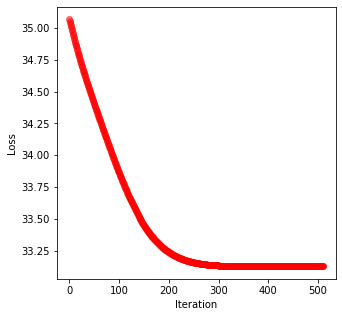

In [38]:
sol = Solver(n_qubits=3)
indexed_circuit = [6,7,8,9,10,11]
circuit, symbols, index_to_symbols = sol.give_circuit(indexed_circuit)
symbol_to_value, energy, h = sol.compute_energy_first_time(circuit, symbols,[1000,0.01]) ##very nie 5000, 0.01
u1 = sol.give_unitary(indexed_circuit, symbol_to_value)
print("initial energy: ", energy)
plot(h.history["loss"])
u1

In [39]:
simplified, _ = sol.kill_one_unitary(indexed_circuit, index_to_symbols, symbol_to_value, historial_lowest_energy=energy)
if simplified:
    indexed_circuit, index_to_symbols, symbol_to_value = _
    print(diff_expectation(sol.give_unitary(indexed_circuit, symbol_to_value), u1, whole=True))

[-1.4999998, -1.4999983]


In [40]:
sol.give_unitary(indexed_circuit, symbol_to_value)

(0, 0): ───Rz(0.395π)───Rx(0)───

(0, 1): ───Rz(0.674π)───Rx(0)───

(0, 2): ───Rz(0.33π)────────────

Example II: try with a different ansatz and more difficult hamiltonian

initial energy:  -1.6687323


(0, 0): ───Rz(0.202π)────Rx(0.176π)───@───@───Rz(0.5π)───
                                      │   │
(0, 1): ───Rz(1.28π)─────Rx(0)────────X───┼───X──────────
                                          │   │
(0, 2): ───Rz(-0.309π)───Rx(0)────────────X───@──────────

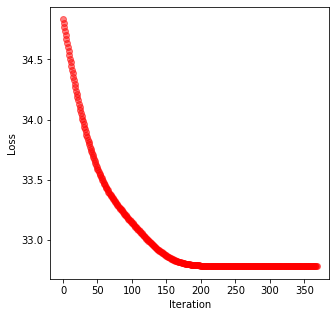

In [42]:
sol = Solver(n_qubits=3, J=1.21)
indexed_circuit = [6,7,8,9,10,11,0,1,6,5]
circuit, symbols, index_to_symbols = sol.give_circuit(indexed_circuit)
symbol_to_value, energy, h = sol.compute_energy_first_time(circuit, symbols,[1000,0.01]) ##very nie 5000, 0.01
u1 = sol.give_unitary(indexed_circuit, symbol_to_value)
print("initial energy: ", energy)
plot(h.history["loss"])
u1

In [43]:
simplified, _ = sol.kill_one_unitary(indexed_circuit, index_to_symbols, symbol_to_value, historial_lowest_energy=energy)
if simplified:
    indexed_circuit, index_to_symbols, symbol_to_value = _
    print(diff_expectation(sol.give_unitary(indexed_circuit, symbol_to_value), u1, whole=True))

[-1.6687326, -1.6687324]


In [44]:
sol.give_unitary(indexed_circuit, symbol_to_value)

(0, 0): ───Rz(0.202π)────Rx(0.176π)───@───@───Rz(0.5π)───
                                      │   │
(0, 1): ───Rz(1.28π)──────────────────X───┼───X──────────
                                          │   │
(0, 2): ───Rz(-0.309π)───Rx(0)────────────X───@──────────